## Copmparing Sparse Regularization with Elastic Net with ILC Regularization

### Installations and imports

In [116]:
!pip install -q git+git://github.com/deepmind/optax.git
!pip install -q git+https://github.com/deepmind/dm-haiku

In [117]:
from typing import Any, Generator, Mapping, Tuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from optax._src import transform
from jax import jit, grad, vmap
from jax.tree_util import tree_structure

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.pyplot import figure

### AND-mask optax class definition

In [118]:
class ANDMaskState(optax.OptState):
  """Stateless.""" # Following optax code style

def and_mask(agreement_threshold: float) -> optax.GradientTransformation:
  def init_fn(_):
    # Required by optax
    return ANDMaskState()

  def update_fn(updates, opt_state, params=None):

    def and_mask(update):
      # Compute the masked gradients for a single parameter tensor
      mask = jnp.abs(jnp.mean(jnp.sign(update), 0)) >= agreement_threshold
      mask = mask.astype(jnp.float32)
      avg_update = jnp.mean(update, 0)
      mask_t = mask.sum() / mask.size
      update = mask * avg_update * (1. / (1e-10 + mask_t))
      return update

    del params # Following optax code style
    
    # Compute the masked gradients over all parameters

    # jax.tree_map maps a function (lambda function in this case) over a pytree to produce a new pytree.
    updates = jax.tree_map(lambda x: and_mask(x), updates)
    return updates, opt_state

  return transform.GradientTransformation(init_fn, update_fn)

### MNIST Classification: Layers:(input, 500, 500, 10), (Optional) Regularizer: Yes, ILC: Yes

In [ ]:
"""MNIST classifier example."""


OptState = Any
Batch = Mapping[str, np.ndarray]


def net_fn(batch) -> jnp.ndarray:
  
  x = jnp.array(batch, jnp.float32) / 255.
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(500), jax.nn.relu, # 300
      hk.Linear(500), jax.nn.relu, # 1000
      hk.Linear(10),
  ])
  return mlp(x)


def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
    ) -> Generator[Batch, None, None]:
    """Loads the dataset as a generator of batches."""
    ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))


# Make the network and optimiser.
net = hk.without_apply_rng(hk.transform(net_fn))
# opt = optax.adam(1e-3)
agreement_threshold = 0.8
opt = optax.chain(and_mask(agreement_threshold),optax.adam(1e-3)
    # ,optax.scale_by_adam()
    )

    
# Training loss (cross-entropy).
def loss(params: hk.Params, batch, label) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(label, 10)

    # # L1 Loss
    # sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
    # sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    # l1_loss = sum(sum_p_layers)

    # # L2 Loss
    # l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    # Cross Entropy Loss
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]
    return softmax_xent # + 1e-4 * l2_loss + 1e-5 * l1_loss

    
# Regularization loss (L1,L2).
def regularization_loss(params: hk.Params) -> jnp.ndarray:
    """Compute the regularization loss of the network, applied after ILC."""

    # L1 Loss
    sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
    sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    l1_loss = sum(sum_p_layers)

    # L2 Loss
    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    return 1e-4 * l2_loss + 1e-5 * l1_loss

@jax.jit
def gradient_per_sample(params, batch, label):
    batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
    return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)


# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
    predictions = net.apply(params, batch)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

@jax.jit
def update(
      params: hk.Params,
      opt_state: OptState,
      batch, label
    ) -> Tuple[hk.Params, OptState]:
    """Learning rule (stochastic gradient descent)."""
    # grads = jax.grad(loss)(params, batch, label)
    grads_masked = (gradient_per_sample)(params, batch, label)
    sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,grads_masked,jax.grad(regularization_loss)(params))
    grads = sum_grad_masked_regularized
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state
    
# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation.
# For more, see: https://doi.org/10.1137/0330046
@jax.jit
def ema_update(
      avg_params: hk.Params,
      new_params: hk.Params,
      epsilon: float = 0.001,
  ) -> hk.Params:
    return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                             avg_params, new_params)

# Make datasets.
train = load_dataset("train", is_training=True, batch_size=1000)
train_eval = load_dataset("train", is_training=False, batch_size=10000)
test_eval = load_dataset("test", is_training=False, batch_size=10000)

# Initialize network and optimiser; note we draw an input to get shapes.
params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['image'])
opt_state = opt.init(params)

# print(jax.grad(loss)(params, next(train)))

# Train/eval loop.
for step in range(10001):
    if step % 1000 == 0:
      # Periodically evaluate classification accuracy on train & test sets.
      Batch = next(train_eval)
      train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
      Batch = next(test_eval)
      test_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
      train_accuracy, test_accuracy = jax.device_get(
          (train_accuracy, test_accuracy))
      print(f"[Step {step}] Train / Test accuracy: "
            f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

    # Do SGD on a batch of training examples.

    Batch = next(train)
    params, opt_state = update(params, opt_state, Batch['image'], Batch['label'])
    avg_params = ema_update(avg_params, params)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
[Step 0] Train / Test accuracy: 0.141 / 0.133.
[Step 1000] Train / Test accuracy: 0.936 / 0.933.
[Step 2000] Train / Test accuracy: 0.980 / 0.970.
[Step 3000] Train / Test accuracy: 0.990 / 0.976.
[Step 4000] Train / Test accuracy: 0.995 / 0.977.
[Step 5000] Train / Test accuracy: 0.995 / 0.975.
[Step 6000] Train / Test accuracy: 0.998 / 0.978.
[Step 7000] Train / Test accuracy: 0.999 / 0.979.


KeyboardInterrupt: ignored

### Sparse Logistic Regression with MNIST (Only the NN architecture differs from the above cell)

In [ ]:
"""MNIST classifier example."""


OptState = Any
Batch = Mapping[str, np.ndarray]


def net_fn(batch) -> jnp.ndarray:
  
  x = jnp.array(batch, jnp.float32) / 255.
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(10),
  ])
  return mlp(x)


def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
    ) -> Generator[Batch, None, None]:
    """Loads the dataset as a generator of batches."""
    ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))


# Make the network and optimiser.
net = hk.without_apply_rng(hk.transform(net_fn))
# opt = optax.adam(1e-3)
agreement_threshold = 0.7
use_ilc = True
opt = optax.chain(and_mask(agreement_threshold),optax.adam(1e-3)
    # ,optax.scale_by_adam()
    )

   
# Training loss (cross-entropy).
def loss(params: hk.Params, batch, label) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(label, 10)

    # # L1 Loss
    # sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
    # sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    # l1_loss = sum(sum_p_layers)

    # # L2 Loss
    # l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    # Cross Entropy Loss
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]
    return softmax_xent # + 1e-4 * l2_loss + 1e-5 * l1_loss

    
# Regularization loss (L1,L2).
def regularization_loss(params: hk.Params) -> jnp.ndarray:
    """Compute the regularization loss of the network, applied after ILC."""

    # L1 Loss
    sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
    sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    l1_loss = sum(sum_p_layers)

    # L2 Loss
    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    return 1e-4 * l2_loss + 1e-5 * l1_loss


@jax.jit
def gradient_per_sample(params, batch, label):
    batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
    return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

gradient = jax.jit(grad(loss))

# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
    predictions = net.apply(params, batch)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

@jax.jit
def update(
      params: hk.Params,
      opt_state: OptState,
      batch, label
    ) -> Tuple[hk.Params, OptState]:
    """Learning rule (stochastic gradient descent)."""
    # grads = jax.grad(loss)(params, batch, label)
    grads_masked = (gradient_per_sample)(params, batch, label)
    sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,grads_masked,jax.grad(regularization_loss)(params))
    grads = sum_grad_masked_regularized
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state
    

# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation.
# For more, see: https://doi.org/10.1137/0330046
@jax.jit
def ema_update(
      avg_params: hk.Params,
      new_params: hk.Params,
      epsilon: float = 0.001,
  ) -> hk.Params:
    return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                             avg_params, new_params)

# Make datasets.
train = load_dataset("train", is_training=True, batch_size=1000)
train_eval = load_dataset("train", is_training=False, batch_size=10000)
test_eval = load_dataset("test", is_training=False, batch_size=10000)

# Initialize network and optimiser; note we draw an input to get shapes.
params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['image'])
opt_state = opt.init(params)

# print(jax.grad(loss)(params, next(train)))

# Train/eval loop.
for step in range(10001):
    if step % 1000 == 0:
      # Periodically evaluate classification accuracy on train & test sets.
      Batch = next(train_eval)
      train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
      Batch = next(test_eval)
      test_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
      train_accuracy, test_accuracy = jax.device_get(
          (train_accuracy, test_accuracy))
      print(f"[Step {step}] Train / Test accuracy: "
            f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

    # Do SGD on a batch of training examples.

    Batch = next(train)
    params, opt_state = update(params, opt_state, Batch['image'], Batch['label'])

    avg_params = ema_update(avg_params, params)

[Step 0] Train / Test accuracy: 0.063 / 0.065.
[Step 1000] Train / Test accuracy: 0.854 / 0.859.
[Step 2000] Train / Test accuracy: 0.879 / 0.883.
[Step 3000] Train / Test accuracy: 0.886 / 0.891.
[Step 4000] Train / Test accuracy: 0.896 / 0.895.
[Step 5000] Train / Test accuracy: 0.899 / 0.896.
[Step 6000] Train / Test accuracy: 0.897 / 0.897.
[Step 7000] Train / Test accuracy: 0.901 / 0.898.
[Step 8000] Train / Test accuracy: 0.898 / 0.898.
[Step 9000] Train / Test accuracy: 0.899 / 0.899.
[Step 10000] Train / Test accuracy: 0.903 / 0.899.


### Sparse Logistic Regression Function (For reusability)

In [119]:
OptState = Any
Batch = Mapping[str, np.ndarray]

def sparse_logistic_regression(train, adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-5, l2_coef=1e-4,
                               epochs=10001, Verbose=False, n_classes=10, normalizer=255.):



    def net_fn(batch) -> jnp.ndarray:
    
        x = jnp.array(batch, jnp.float32) / normalizer
        mlp = hk.Sequential([
            hk.Flatten(),
            hk.Linear(n_classes),
        ])
        return mlp(x)


    # Make the network and optimiser.
    net = hk.without_apply_rng(hk.transform(net_fn))


       
    # Training loss (cross-entropy).
    def loss(params: hk.Params, batch, label) -> jnp.ndarray:
        """Compute the loss of the network, including L2."""
        logits = net.apply(params, batch)
        labels = jax.nn.one_hot(label, 10)

        # # L1 Loss
        # sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
        # sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
        # l1_loss = sum(sum_p_layers)

        # # L2 Loss
        # l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

        # Cross Entropy Loss
        softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
        softmax_xent /= labels.shape[0]
        return softmax_xent # + 1e-4 * l2_loss + 1e-5 * l1_loss

        
    # Regularization loss (L1,L2).
    def regularization_loss(params: hk.Params) -> jnp.ndarray:
        """Compute the regularization loss of the network, applied after ILC."""

        # L1 Loss
        sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
        sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
        l1_loss = sum(sum_p_layers)

        # L2 Loss
        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

        return l2_coef * l2_loss + l1_coef * l1_loss
    

    @jax.jit
    def gradient_per_sample(params, batch, label):
        batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
        return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

    gradient = jax.jit(grad(loss))
    gradient_reg = jax.jit(grad(regularization_loss))
    # Evaluation metric (classification accuracy).
    @jax.jit
    def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
        predictions = net.apply(params, batch)
        return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

    
    @jax.jit
    def update(
        params: hk.Params,
        opt_state: OptState,
        batch, label
        ) -> Tuple[hk.Params, OptState]:
        """Learning rule (stochastic gradient descent)."""
        # grads = jax.grad(loss)(params, batch, label)
        grads_masked = (gradient_per_sample if use_ilc else gradient)(params, batch, label) # (gradient_per_sample)(params, batch, label)
        sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,grads_masked,gradient_reg(params))
        grads = sum_grad_masked_regularized
        updates, opt_state = opt.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state


    # We maintain avg_params, the exponential moving average of the "live" params.
    # avg_params is used only for evaluation.
    # For more, see: https://doi.org/10.1137/0330046
    @jax.jit
    def ema_update(
        avg_params: hk.Params,
        new_params: hk.Params,
        epsilon: float = 0.001,
    ) -> hk.Params:
        return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                                avg_params, new_params)

    
    use_ilc = False

    opt = optax.chain(optax.adam(adam_lr)
        # ,optax.scale_by_adam()
        )
    # Initialize network and optimiser; note we draw an input to get shapes.
    params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['image'])
    opt_state = opt.init(params)


    # Train/eval loop. WITHOUT ILC
    for step in range(np.int(epochs/2)):
        if step % np.int(epochs/10) == 0:
            # Periodically evaluate classification accuracy on train & test sets.
            Batch = next(train)
            train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
            train_accuracy = jax.device_get(train_accuracy)
            if Verbose:
                print(f"[ILC Off, Step {step}] Train accuracy: "
                        f"{train_accuracy:.3f}.")

        # Do SGD on a batch of training examples.
        Batch = next(train)
        params, opt_state = update(params, opt_state, Batch['image'], Batch['label'])
        avg_params = ema_update(avg_params, params)
    

    use_ilc = True

    opt = optax.chain(and_mask(agreement_threshold),optax.adam(adam_lr)
        # ,optax.scale_by_adam()
        )
    # Initialize network and optimiser; note we draw an input to get shapes.
    opt_state = opt.init(params)


    # Train/eval loop. WITH ILC
    for step in range(np.int(epochs/2)):
        if step % np.int(epochs/10) == 0:
            # Periodically evaluate classification accuracy on train & test sets.
            Batch = next(train)
            train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
            train_accuracy = jax.device_get(train_accuracy)
            if Verbose:
                print(f"[ILC On, Step {step}] Train accuracy: "
                        f"{train_accuracy:.3f}.")

        # Do SGD on a batch of training examples.
        Batch = next(train)
        params, opt_state = update(params, opt_state, Batch['image'], Batch['label'])
        avg_params = ema_update(avg_params, params)
    return params

### If you want to get the results for a single environment, use these cells with whatever regularization (l1,l2,ilc)

In [ ]:
avg_params = sparse_logistic_regression(train, adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-5, l2_coef=1e-4,
                               epochs=10001, Verbose=True)

(784, 10)


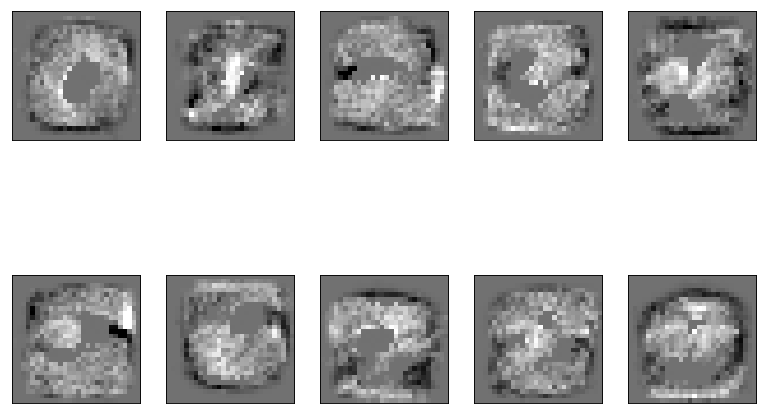

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print(avg_params['linear']['w'].shape)
fig, axes = plt.subplots(2, 5, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = avg_params['linear']['w'].min(), avg_params['linear']['w'].max()
for coef, ax in zip(avg_params['linear']['w'].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

### Use this cell to train on n_envs number of environments with elastic net regularizer but no ilc (you can change it to include ilc as well)

In [ ]:
n_envs = 4
ds_train_envs = []
batch_size = 1000
splits = tfds.even_splits('train', n=n_envs)
for m in range(n_envs):
    ds = tfds.load("mnist:3.*.*", split=splits[m]).cache().repeat()
    ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    ds_train_envs.append(iter(tfds.as_numpy(ds)))

envs_elastic_net_params = []
for m in range(n_envs):
    params = sparse_logistic_regression(ds_train_envs[m], adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-4, l2_coef=1e-5,
                               epochs=10001, Verbose=True)
    envs_elastic_net_params.append(params)

### Use this cell to train on n_envs number of environments with ilc but not elastic net regularizer (you can change it to include ilc as well)

In [ ]:
n_envs = 2
ds_train_envs = []
batch_size = 1000
splits = tfds.even_splits('train', n=n_envs)
for m in range(n_envs):
    ds = tfds.load("mnist:3.*.*", split=splits[m]).cache().repeat()
    ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    ds_train_envs.append(iter(tfds.as_numpy(ds)))

envs_ilc_params = []
for m in range(n_envs):
    params = sparse_logistic_regression(ds_train_envs[m], adam_lr=1e-3, agreement_threshold=0.9,
                               use_ilc=True, l1_coef=0., l2_coef=1e-4,
                               epochs=10001, Verbose=True)
    envs_ilc_params.append(params)

[ILC Off, Step 0] Train accuracy: 0.067.
[ILC Off, Step 1000] Train accuracy: 0.910.
[ILC Off, Step 2000] Train accuracy: 0.913.
[ILC Off, Step 3000] Train accuracy: 0.914.
[ILC Off, Step 4000] Train accuracy: 0.939.
[ILC On, Step 0] Train accuracy: 0.937.
[ILC On, Step 1000] Train accuracy: 0.944.
[ILC On, Step 2000] Train accuracy: 0.941.
[ILC On, Step 3000] Train accuracy: 0.946.
[ILC On, Step 4000] Train accuracy: 0.941.
[ILC Off, Step 0] Train accuracy: 0.073.
[ILC Off, Step 1000] Train accuracy: 0.892.
[ILC Off, Step 2000] Train accuracy: 0.929.
[ILC Off, Step 3000] Train accuracy: 0.934.
[ILC Off, Step 4000] Train accuracy: 0.936.
[ILC On, Step 0] Train accuracy: 0.933.
[ILC On, Step 1000] Train accuracy: 0.942.
[ILC On, Step 2000] Train accuracy: 0.921.
[ILC On, Step 3000] Train accuracy: 0.938.
[ILC On, Step 4000] Train accuracy: 0.927.


### Sicne we want to explore resulting weights for various hyperparameters, it'd be better to store them with a proper name to be plotted later. Change the name when you store a parameter according to the regularizers and their value.

In [ ]:
import pickle
root_dir = '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/'

def storeData(object, file_name, root_dir):
    with open(root_dir+file_name, 'wb') as f:
        pickle.dump(object, f)					 
        f.close() 

def loadData(file_name, root_dir): 
    with open(root_dir+file_name, 'rb') as f:
        db = pickle.load(f) 
        f.close()
        return db

# storeData(envs_elastic_net_params, 'envs_elastic_net_params', root_dir)
storeData(envs_ilc_params, 'envs_ilc_params_l24_agth_09_late_turn_on_ilc_before_reg', root_dir)


# envs_elastic_net_params = loadData('envs_elastic_net_params_l14_l25', root_dir)
# envs_ilc_params = loadData('envs_ilc_params_l24_agth_03', root_dir)

### Agreement Threshold = 0.9, `l2 coef=1e-4` ILC Started after 5 epochs (out of 10). ILC applied BEFORE Regularization

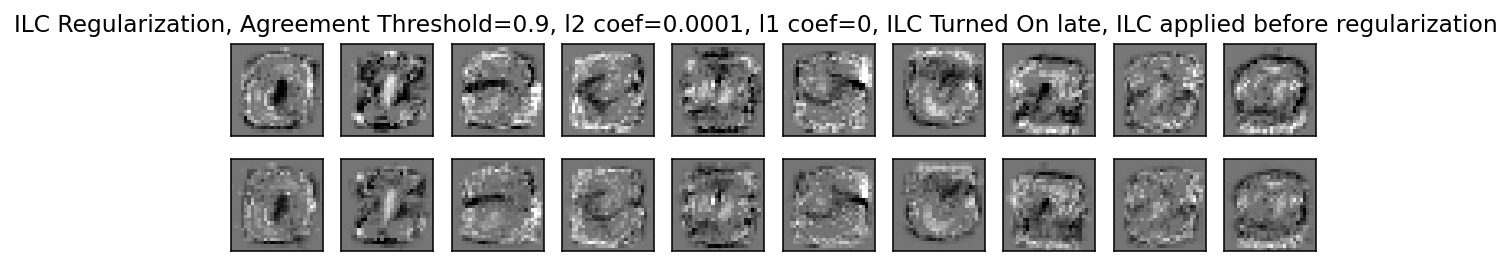

In [ ]:
def sparse_selections_plotter(envs_params, regularization, ag_thresh, l2, l1, latestart, ilc_before):

    fig, axes = plt.subplots(len(envs_params), 10, figsize=(10, 2), dpi=140, facecolor='w', edgecolor='k')
    # use global min / max to ensure all weights are shown on the same scale
    for m in range(len(envs_params)):
        vmin, vmax = envs_params[m]['linear']['w'].min(), envs_params[m]['linear']['w'].max()
        for coef, ax in zip(envs_params[m]['linear']['w'].T, axes[m,:]):
            ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                    vmax=.5 * vmax)
            ax.set_xticks(())
            ax.set_yticks(())

    title = regularization+' Regularization, Agreement Threshold='+ag_thresh+', l2 coef='+l2+', l1 coef='+l1
    if latestart: title = str(title) + ', ILC Turned On late'
    if ilc_before: title =str(title) + ', ILC applied before regularization'
    plt.suptitle(title)
    plt.show()

sparse_selections_plotter(envs_ilc_params, 'ILC', str(0.9), str(1e-4), str(0), True, True)

In [ ]:
!pip freeze > requirements.txt

### MAIN CELL: Experimenting a range of hyperparameters

In [ ]:
# at = [0.2, 0.9]
# ll1 = [1e-3, 1e-4, 1e-5]
# ll2 = [1e-3, 1e-4, 1e-5]
# all = []
at = [0.0, 0.2, 0.4, 0.5, 0.7, 0.9]
ll1 = [1e-1, 1e-2, 1e-3]
ll2 = [1e-3, 1e-4, 1e-5]
all = []

ds_train_envs = []
splits = tfds.even_splits('train', n=n_envs)
for m in range(n_envs):
    ds = tfds.load("mnist:3.*.*", split=splits[m]).cache().repeat()
    ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    ds_train_envs.append(iter(tfds.as_numpy(ds)))


round = 0
for idx, thresh in enumerate(at):
  for l1 in ll1:
    for l2 in ll2:
      round += 1
      print('Round: ', round)

      envs_elastic_net_params = []
      hp = {}
      hp['thresh'] = thresh
      hp['l1'] = l1
      hp['l2'] = l2
      hp['params'] = []
      for m in range(n_envs):
        print('Parameters=[l1={}, l2={}, agreement={}], Environment={}'.format(l1,l2,thresh, m))
        params = sparse_logistic_regression(ds_train_envs[m], adam_lr=1e-3, agreement_threshold=thresh,
                                  use_ilc=True, l1_coef=l1, l2_coef=l2,
                                  epochs=10001, Verbose=True)
        envs_elastic_net_params.append(params)
        hp['params'].append(params)
      all.append(hp)

Round:  1
Parameters=[l1=0.1, l2=0.001, agreement=0.0], Environment=0
[ILC Off, Step 0] Train accuracy: 0.067.
[ILC Off, Step 1000] Train accuracy: 0.075.
[ILC Off, Step 2000] Train accuracy: 0.078.
[ILC Off, Step 3000] Train accuracy: 0.101.
[ILC Off, Step 4000] Train accuracy: 0.168.
[ILC On, Step 0] Train accuracy: 0.368.
[ILC On, Step 1000] Train accuracy: 0.608.
[ILC On, Step 2000] Train accuracy: 0.654.
[ILC On, Step 3000] Train accuracy: 0.671.
[ILC On, Step 4000] Train accuracy: 0.686.
Parameters=[l1=0.1, l2=0.001, agreement=0.0], Environment=1
[ILC Off, Step 0] Train accuracy: 0.073.
[ILC Off, Step 1000] Train accuracy: 0.062.
[ILC Off, Step 2000] Train accuracy: 0.078.
[ILC Off, Step 3000] Train accuracy: 0.098.
[ILC Off, Step 4000] Train accuracy: 0.175.
[ILC On, Step 0] Train accuracy: 0.379.
[ILC On, Step 1000] Train accuracy: 0.568.
[ILC On, Step 2000] Train accuracy: 0.632.
[ILC On, Step 3000] Train accuracy: 0.668.
[ILC On, Step 4000] Train accuracy: 0.680.
Round:  2
Pa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


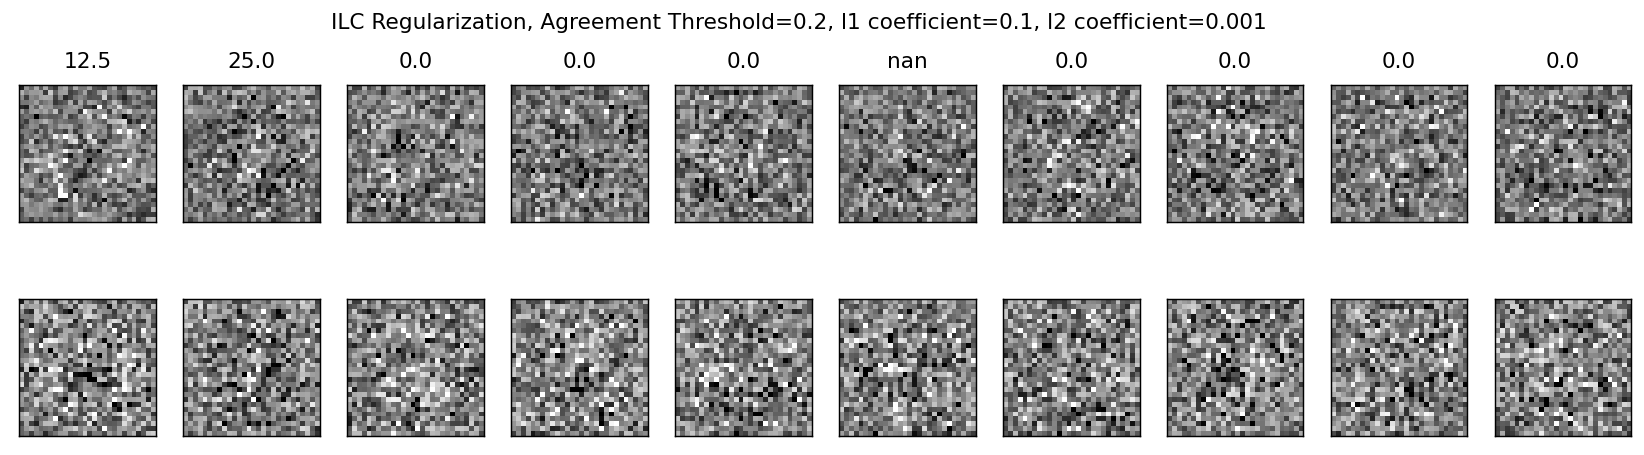

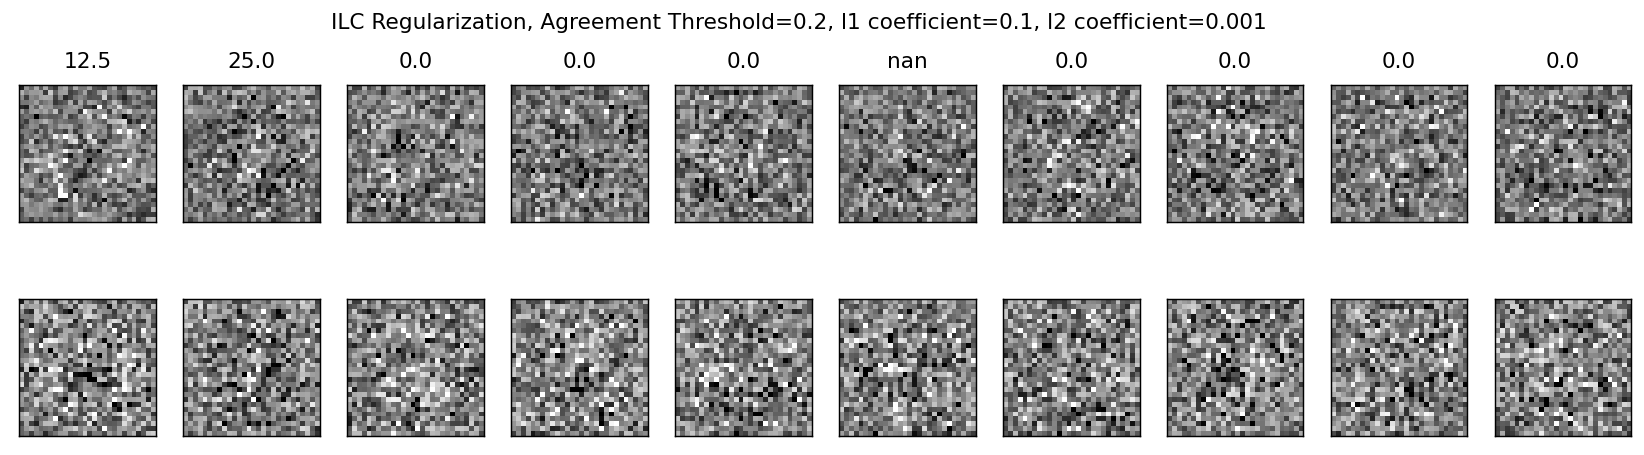

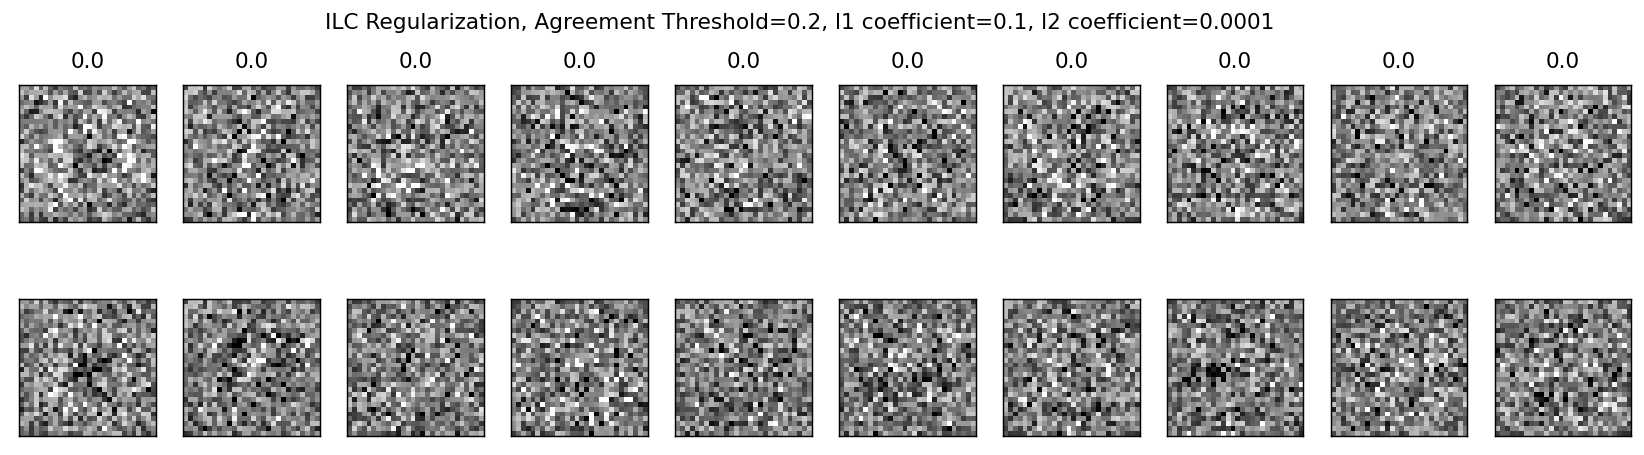

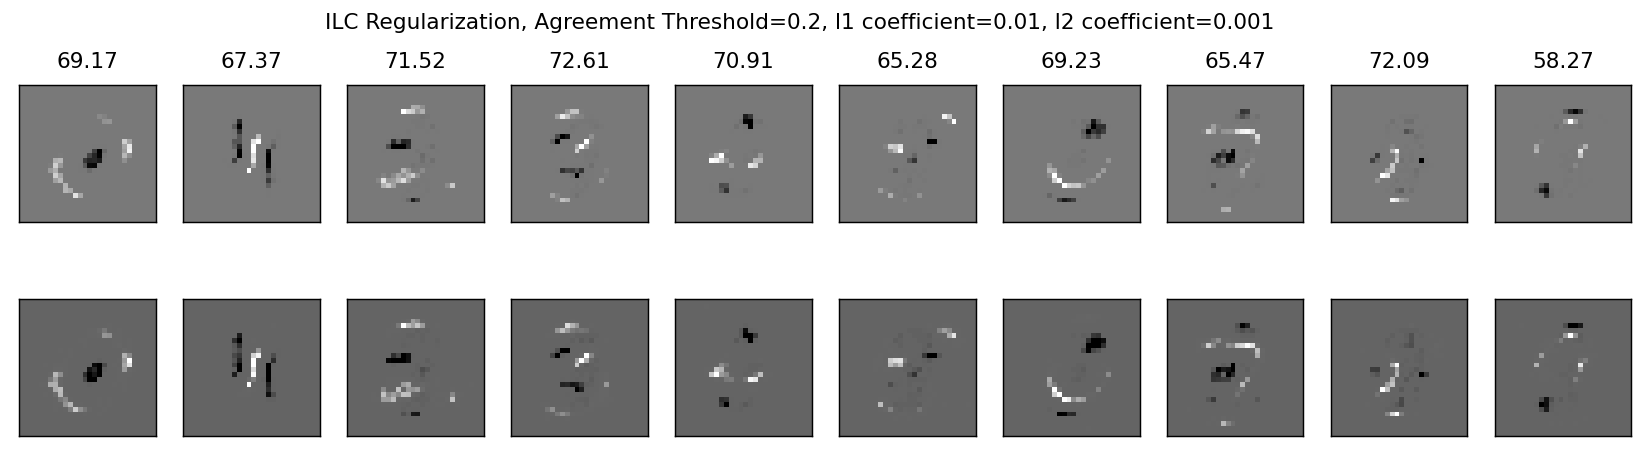

In [124]:
num=0
setting_overlaps = np.zeros([len(all),10])
for r in all:
  num += 1
  envs_elastic_net_params = r['params']
  fig, axes = plt.subplots(len(envs_elastic_net_params), 10, figsize=(16, 4), dpi=130, facecolor='w', edgecolor='k')
  # use global min / max to ensure all weights are shown on the same scale
  for m in range(n_envs):
      vmin, vmax = envs_elastic_net_params[m]['linear']['w'].min(), envs_elastic_net_params[m]['linear']['w'].max()
      for coef, ax in zip(envs_elastic_net_params[m]['linear']['w'].T, axes[m,:]):
          ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                  vmax=.5 * vmax)
          ax.set_xticks(())
          ax.set_yticks(())

  env1_w = envs_elastic_net_params[0]['linear']['w'].T.round(3)
  env2_w = envs_elastic_net_params[1]['linear']['w'].T.round(3)
      
  caps = []
  for digit in range(10):

    env1_digit_sparse_selectors = np.array([1 if np.abs(env1_w[digit, m]) > 0.0 else 0 for m in range(784)])
    env2_digit_sparse_selectors = np.array([1 if np.abs(env2_w[digit, m]) > 0.0 else 0 for m in range(784)])

    overlapping_selectors = env1_digit_sparse_selectors*env2_digit_sparse_selectors.transpose()

    overlap_percentage = ((100*(sum(overlapping_selectors)))/(np.max([sum(env1_digit_sparse_selectors),sum(env2_digit_sparse_selectors)]))).round(2)

    setting_overlaps[num-1, digit] = overlap_percentage
    caps.append(overlap_percentage)

  for ax, col in zip(axes[0], caps):
      ax.set_title(col)
  one = r['thresh']
  two = r['l1']
  three = r['l2']
  plt.suptitle('ILC Regularization, Agreement Threshold={}, l1 coefficient={}, l2 coefficient={}'.format(one,two,three))
  plt.savefig(f'{num}.png')
  plt.show()

### Synthetic Data Experiment

In [ ]:
import numpy as np 
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils

import pickle

# In case we wanted to do experiments with ILC inter subjects.
# This class is also good when we want to deal with different runs from the same
# subject.
class fmriDatasetAllSubjects(Dataset):
    """fMRI dataset when all subjects data is mixed."""

    def __init__(self, root_dir, files_paths, list_of_partitions, list_of_labels, format, transform=None):
        # event_file could be added when real data is available.
        # add this argument later: tsv_file
        """
        Args:
            files_paths (string): Path to the (fmri) file (nifti or npy).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample, i.e. flattening and subsampling.
        """
        self.root_dir = root_dir

        self.labels = list_of_labels

        self.path = os.path.join(self.root_dir, files_paths)
    
        images = np.load(self.path, encoding='bytes')
        images = images[list_of_partitions,:,:,:]
        images = np.reshape(images, (images.shape[1],images.shape[2],images.shape[3],images.shape[0]))

        
        self.subject_frames = images

        self.transform = transform

    def __len__(self):
        return (self.subject_frames).shape[3]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.subject_frames[:,:,:,idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, self.labels[idx]

# In case we wanted to do experiments with ILC intra subjects
class fmriDatasetSubject(Dataset):
    """fMRI dataset for each subject."""

    def __init__(self, root_dir, file_path, list_IDs, labels, format, transform=None):
        # event_file could be added when real data is available.
        # add this argument later: tsv_file
        """
        Args:
            file_path (string): Path to the (fmri) file (nifti or npy).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample, i.e. flattening and subsampling.
        """
        
        self.root_dir = root_dir
        self.file_path = file_path
        self.labels = labels
        self.path = os.path.join(self.root_dir, self.file_path)
        
    
        images = np.load(self.path, encoding='bytes')
        images = images[list_IDs,:,:,:]
        images = np.reshape(images, (images.shape[1],images.shape[2],images.shape[3],images.shape[0]))
        self.subject_frames = images


        self.transform = transform

    def __len__(self):
        return (self.subject_frames).shape[3]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.subject_frames[:,:,:,idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, self.labels[idx]

class Flatten(object):
    """flatten the 3D image of a timestep.

    Args:
    """

    def __init__(self):
        pass

    def __call__(self, sample):

        dim_x = sample.shape[0]
        dim_y = sample.shape[1]
        dim_z = sample.shape[2]

        sample = sample.reshape(dim_x*dim_y,dim_z)
        sample = sample.reshape(sample.shape[0]*dim_z)
        return sample

class Subsample(object):
    """subsample the 3D image of a timestep.

    Args:
    """

    def __init__(self, subsample_rate_x,subsample_rate_y,subsample_rate_z):
        self.rate_x = subsample_rate_x
        self.rate_y = subsample_rate_y
        self.rate_z = subsample_rate_z

    def __call__(self, sample):

        dim_x = sample.shape[0]
        dim_y = sample.shape[1]
        dim_z = sample.shape[2]

        indexes_x = range(0,dim_x,self.rate_x)
        indexes_y = range(0,dim_y,self.rate_y)
        indexes_z = range(0,dim_z,self.rate_z)

        sample = sample[indexes_x,:,:]
        sample = sample[:,indexes_y,:]
        sample = sample[:,:,indexes_z]

        return sample

root_dir = '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/'

In [ ]:
x = np.load(root_dir+'X_synthetic.npy')
y = np.load(root_dir+'y_synthetic.npy')
print(x)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


# plt.matshow(coef.reshape(28, 28), cmap=plt.cm.gray)
# plt.suptitle('ILC Regularization, Agreement Threshold=0.9')
# plt.show()

[[ 5.29215704  1.20047163  0.77885005 ...  5.35761148  0.38073628
   1.20596809]
 [ 5.64945209 -4.04327718  0.52234535 ...  2.47051246  6.48970785
   4.00958385]
 [-1.10754551 -0.71813753 -1.41423293 ...  1.74886104 -4.11999345
  -4.11999345]
 ...
 [ 0.8781874   0.39192907  0.25683747 ...  2.91662146 -2.75685143
   1.98972149]
 [-0.4004742  -4.69911101 -0.50138221 ...  0.21254279  7.30718552
   2.91504359]
 [-2.79888662  8.59561062  0.19496191 ...  1.55061654 -0.09876208
   3.8943343 ]]


In [ ]:
OptState = Any
Batch = Mapping[str, np.ndarray]

def sparse_logistic_regression_synthetic_data(train, test, adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-5, l2_coef=1e-4,
                               epochs=10001, Verbose=False, n_classes=10, normalizer=255.):

    def evaluate(params, validation_data, validation_labels):
    
        logits = net.apply(params, validation_data)
        preds = jax.nn.log_softmax(logits)
        pred_labels = np.argmax(preds, axis=1)

        acc = accuracy(params, validation_data, validation_labels)
        # As mentioned before, data is unbalanced, hence, the accuracy itself is not 
        # enough for evaluating the performance of the model.
        # print(outputs,local_labels.cpu().detach().numpy())
        cm = confusion_matrix(pred_labels.transpose(), validation_labels.transpose())
        sns.set_theme()
        plt.figure()
        ax = sns.heatmap(cm)
        print('\nConfusion Matrix: ', cm)
        precision,recall,fscore,_ = precision_recall_fscore_support(validation_labels, pred_labels)
        print('\nAccuracy: ', acc,'\nPrecision: ',precision,'\nRecall: ', recall,'\nF-score: ', fscore)


    def net_fn(batch) -> jnp.ndarray:
    
        x = jnp.array(batch, jnp.float32) / normalizer
        mlp = hk.Sequential([
            hk.Flatten(),
            hk.Linear(n_classes),
        ])
        return mlp(x)


    # Make the network and optimiser.
    net = hk.without_apply_rng(hk.transform(net_fn))

    
    # Training loss (cross-entropy).
    def loss(params: hk.Params, batch, label) -> jnp.ndarray:
        """Compute the loss of the network, including L1, and L2."""
        logits = net.apply(params, batch)
        labels = jax.nn.one_hot(label, n_classes)

        # L1 Loss
        sum_in_layer = lambda p: jnp.sum(p)
        sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
        l1_loss = sum(sum_p_layers)

        # L2 Loss
        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

        # Cross Entropy Loss
        softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
        softmax_xent /= labels.shape[0]
        return softmax_xent + l2_coef * l2_loss + l1_coef * l1_loss

    @jax.jit
    def gradient_per_sample(params, batch, label):
        batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
        return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

    gradient = jax.jit(grad(loss))

    # Evaluation metric (classification accuracy).
    @jax.jit
    def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
        predictions = net.apply(params, batch)
        return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

    @jax.jit
    def update(
        params: hk.Params,
        opt_state: OptState,
        batch, label
        ) -> Tuple[hk.Params, OptState]:
        """Learning rule (stochastic gradient descent)."""
        # grads = jax.grad(loss)(params, batch, label)
        grads = (gradient_per_sample if use_ilc else gradient)(params, batch, label)
        updates, opt_state = opt.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state

    # We maintain avg_params, the exponential moving average of the "live" params.
    # avg_params is used only for evaluation.
    # For more, see: https://doi.org/10.1137/0330046
    @jax.jit
    def ema_update(
        avg_params: hk.Params,
        new_params: hk.Params,
        epsilon: float = 0.001,
    ) -> hk.Params:
        return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                                avg_params, new_params)



    use_ilc = False

    opt = optax.chain(optax.sgd(adam_lr)
        # ,optax.adam(adam_lr)
        # ,optax.scale_by_adam()
        )
    # Initialize network and optimiser; note we draw an input to get shapes.
    params = avg_params = net.init(jax.random.PRNGKey(42), next(train)[0])
    opt_state = opt.init(params)


    # Train/eval loop. WITHOUT ILC
    for step in range(np.int(epochs/2)):
        if step % np.int(epochs/10) == 0:
            # Periodically evaluate classification accuracy on train & test sets.
            Batch = next(train)
            train_accuracy = accuracy(avg_params, Batch[0], Batch[1])
            train_accuracy = jax.device_get(train_accuracy)
            Batch = next(test)
            test_accuracy = accuracy(avg_params, Batch[0], Batch[1])
            test_accuracy = jax.device_get(test_accuracy)
            if Verbose:
                print(f"[Step {step}] Train accuracy/Test accuracy: "
                        f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

        # Do SGD on a batch of training examples.
        Batch = next(train)
        params, opt_state = update(params, opt_state, Batch[0], Batch[1])
        avg_params = ema_update(avg_params, params)
    

    use_ilc = True

    opt = optax.chain(and_mask(agreement_threshold)
        ,optax.sgd(adam_lr)
        # ,optax.adam(adam_lr)
        # ,optax.scale_by_adam()
        )
    # Initialize network and optimiser; note we draw an input to get shapes.
    opt_state = opt.init(params)


    # Train/eval loop. WITH ILC
    for step in range(np.int(epochs/2)):
        if step % np.int(epochs/10) == 0:
            # Periodically evaluate classification accuracy on train & test sets.
            Batch = next(train)
            train_accuracy = accuracy(avg_params, Batch[0], Batch[1])
            train_accuracy = jax.device_get(train_accuracy)
            Batch = next(test)
            test_accuracy = accuracy(avg_params, Batch[0], Batch[1])
            test_accuracy = jax.device_get(test_accuracy)
            if Verbose:
                print(f"[Step {step}] Train accuracy/Test accuracy: "
                        f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

        # Do SGD on a batch of training examples.
        Batch = next(train)
        params, opt_state = update(params, opt_state, Batch[0], Batch[1])
        avg_params = ema_update(avg_params, params)

    # Train/eval loop.
    # for step in range(epochs):
    #     if step % np.int(epochs/10) == 0:
    #         # Periodically evaluate classification accuracy on train & test sets.
    #         Batch = next(train)
    #         train_accuracy = accuracy(avg_params, Batch[0], Batch[1])
    #         train_accuracy = jax.device_get(train_accuracy)
    #         Batch = next(test)
    #         test_accuracy = accuracy(avg_params, Batch[0], Batch[1])
    #         test_accuracy = jax.device_get(test_accuracy)
    #         if Verbose:
    #             print(f"[Step {step}] Train accuracy/Test accuracy: "
    #                     f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

    #     # Do SGD on a batch of training examples.
    #     Batch = next(train)
    #     params, opt_state = update(params, opt_state, Batch[0], Batch[1])
    #     avg_params = ema_update(avg_params, params)
    
    Batch = next(test)
    test_data, test_labels = Batch[0], Batch[1]
    evaluate(avg_params, test_data, test_labels)

    return params

[Step 0] Train accuracy/Test accuracy: 0.600 / 0.450.
[Step 1000] Train accuracy/Test accuracy: 0.525 / 0.600.
[Step 2000] Train accuracy/Test accuracy: 0.700 / 0.650.
[Step 3000] Train accuracy/Test accuracy: 0.775 / 0.850.
[Step 4000] Train accuracy/Test accuracy: 0.863 / 0.900.
[Step 0] Train accuracy/Test accuracy: 1.000 / 0.850.
[Step 1000] Train accuracy/Test accuracy: 1.000 / 0.850.
[Step 2000] Train accuracy/Test accuracy: 0.938 / 0.900.
[Step 3000] Train accuracy/Test accuracy: 0.988 / 1.000.
[Step 4000] Train accuracy/Test accuracy: 0.988 / 0.900.

Confusion Matrix:  [[ 4  1]
 [ 0 15]]

Accuracy:  0.95 
Precision:  [0.8 1. ] 
Recall:  [1.     0.9375] 
F-score:  [0.88888889 0.96774194]


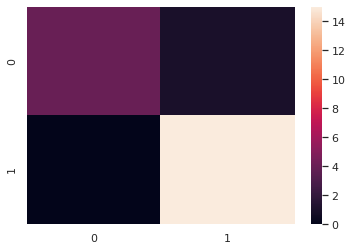

In [ ]:
n_envs = 1
ds_train_envs = []
take = 80
train_batch_size = take
test_batch_size = 100-train_batch_size
np.random.seed(5)
# ds = tfds.load("mnist:3.*.*", split=splits[m]).cache().repeat()
# print(ds)
all_dataset = tf.data.Dataset.from_tensor_slices((x, y)).repeat()
train_dataset = all_dataset.take(take).repeat()
test_dataset = all_dataset.skip(take).repeat()
# print(train_dataset)
# print(test_dataset)
train_dataset = train_dataset.shuffle(10 * train_batch_size, seed=0)
train_dataset = train_dataset.batch(train_batch_size)
train_dataset = iter(tfds.as_numpy(train_dataset))

test_dataset = test_dataset.shuffle(10 * test_batch_size, seed=0)
test_dataset = test_dataset.batch(test_batch_size)
test_dataset = iter(tfds.as_numpy(test_dataset))

params = sparse_logistic_regression_synthetic_data(train_dataset, test_dataset, adam_lr=1e-4, agreement_threshold=0.9,
                               use_ilc=False, l1_coef=1e-5, l2_coef=1e-3,
                               epochs=10001, Verbose=True, n_classes=2, normalizer=1.)


In [ ]:
a = params['linear']['w']
print(a)
a[(2,4,10,20,32),:]

[[ 0.1473984   0.06192082]
 [ 0.10809339 -0.1301655 ]
 [ 0.1335706  -0.08784842]
 [ 0.00612367 -0.10327508]
 [ 0.03174865 -0.07813005]
 [-0.04610916  0.02323778]
 [ 0.0295224   0.01352572]
 [-0.0384958   0.14034608]
 [-0.17396785 -0.03774179]
 [-0.16889475  0.00098516]
 [ 0.04014969  0.01395026]
 [ 0.07354649  0.06875978]
 [-0.1125344   0.14107518]
 [-0.01605109  0.09848054]
 [-0.07691878 -0.00560028]
 [ 0.12801269  0.05562311]
 [ 0.01735174  0.1001538 ]
 [ 0.09804005 -0.00818088]
 [-0.09308257  0.05327222]
 [-0.17089008  0.03709334]
 [-0.00861903 -0.03992877]
 [-0.10983255  0.18286094]
 [ 0.1083269  -0.03129981]
 [-0.16940027  0.03751344]
 [-0.03163346 -0.04857506]
 [-0.05974003  0.13473658]
 [ 0.06295478  0.0477047 ]
 [-0.2008105   0.1662375 ]
 [ 0.09635834 -0.00315371]
 [-0.08470424  0.0511211 ]
 [-0.12163352  0.04133866]
 [ 0.0149353  -0.00465223]
 [-0.00668968 -0.01006213]
 [ 0.12186795  0.03029595]
 [-0.20730631  0.37416324]
 [ 0.00169307 -0.10816658]
 [-0.11045387 -0.01956288]
 

DeviceArray([[ 0.1335706 , -0.08784842],
             [ 0.03174865, -0.07813005],
             [ 0.04014969,  0.01395026],
             [-0.00861903, -0.03992877],
             [-0.00668968, -0.01006213]], dtype=float32)